## SYDE556/750 Assignment 2: Spiking Neurons

- Due Date: Feb 15th: Assignment #2 (due at midnight) 
- Total marks: 20 (20% of final grade)
- Late penalty: 1 mark per day
- It is recommended that you Python.
- *Do not use any code from Nengo*

## 1) Generating a random input signal

### 1.1) Gaussian white noise

Create a function called that generates a randomly varying $x(t)$ signal chosen from a white noise distribution.  Call it 'generate_signal' and ensure that it returns $x(t)$ and $X(\omega)$.

The inputs to the function are:

- ``T``: the length of the signal in seconds
- ``dt``: the time step in seconds
- ``rms``: the root mean square power level of the signal.  That is, the resulting signal should have $\sqrt{{1 \over T} \int{x(t)^2}dt}=rms$
- ``limit``: the maximum frequency for the signal (in Hz)
- ``seed``: the random number seed to use (so we can regenerate the same signal again)

Notes:

- To do Fourier transforms in MATLAB, see [here](http://www.mathworks.com/help/matlab/ref/fft.html)
- To do Fourier transforms in Python, see [here](http://docs.scipy.org/doc/numpy/reference/routines.fft.html)    
- In both cases, the transform takes you from $t$ to $\omega$ (or back the other way).  Importantly, $\omega$ is frequency in *radians*, not in Hz.  
- $\Delta \omega$ will be $2 \pi / T$
- To keep the signal real, $X(\omega)=X(-\omega)^*$ (the complex conjugate: the real parts are equal, and the imaginary parts switch sign)
- When randomly generating $X(\omega)$ values, sample them from a Normal distribution $N(\mu=0,\sigma=1)$.  Remember that these are complex numbers, so sample twice from the distribution; once for the real component and once for the imaginary.
- To implement the ``limit``, set all $X(\omega)$ components with frequencies above the limit to 0
- To implement the ``rms``, generate the signal, compute its RMS power ($\sqrt{{1 \over T} \int{x(t)^2}dt}=rms$) and rescale so it has the desired power.

1. [1 mark] Plot $x(t)$ for three randomly generated signals with ``limit`` at 5, 10, and 20Hz. For each of these, ``T``=1, ``dt``=0.001, and ``rms``=0.5.

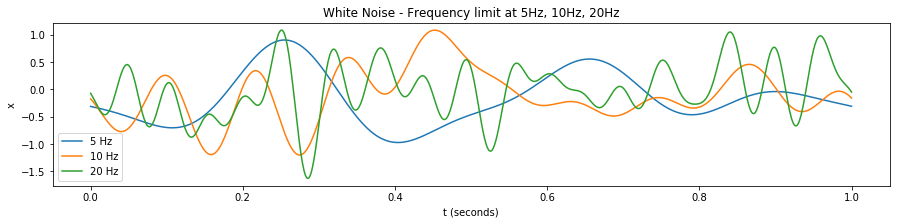

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy


def calc_rms(x):
    return np.sqrt(np.mean(np.power(x,2)))

def generate_signal(T, dt, rms, limit, seed=0):
    
    np.random.seed(seed=seed)
    
    number_of_samples = int(T/dt)
    frequencies=np.arange(number_of_samples)/T - number_of_samples/(2*T)
    X = np.zeros(len(frequencies)).tolist()
    
    for i, f in enumerate(frequencies):
        if abs(f) <= limit:
            real, imag = np.random.normal(), np.random.normal()*1j
            X[i] = real + imag
            if f < 0: X[i] = real - imag
       
    x =np.fft.ifft(np.fft.ifftshift(X)).real
    x_rms = np.sqrt(np.mean(np.power(x,2)))
    x = [val*rms/(x_rms) for val in x]
    X = np.fft.fftshift(numpy.fft.fft(x))   
    return x,X

 
T,dt,rms = 1,0.001,0.5
t = np.linspace(0, T, int(T/dt))

x5, X5 = generate_signal(T, dt, rms, 5, seed=5)
x10, X10 = generate_signal(T, dt, rms, 10, seed=5)
x20, X20 = generate_signal(T, dt, rms, 20, seed=5)


plt.figure(figsize=(15,3))
plt.plot(t, x5, label='5 Hz')
plt.plot(t, x10, label='10 Hz')
plt.plot(t, x20, label='20 Hz')
plt.xlabel('t (seconds)')
plt.ylabel('x')
plt.title('White Noise - Frequency limit at 5Hz, 10Hz, 20Hz')
plt.legend()

2. [1 mark] Plot the average $|X(\omega)|$ (the norm of the Fourier coefficients) over 100 signals generated with ``T``=1, ``dt``=0.001, ``rms``=0.5, and ``limit``=10 (each of these 100 signals should have a different ``seed``). The plot should have the x-axis labeled ($\omega$ in radians) and the average $|X|$ value for that $\omega$ on the y-axis.

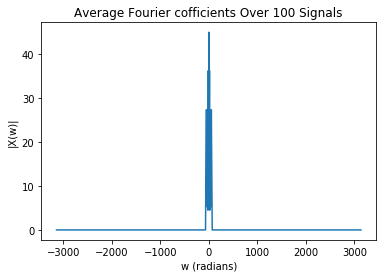

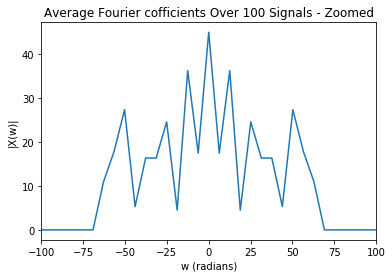

In [2]:
T, dt, rms, limit, num_seeds = 1, 0.001, 0.1, 10, 100
number_of_samples = int(T/dt)

frequencies = sorted(np.fft.fftfreq(number_of_samples,dt))
w = [2*np.pi*f for f in frequencies]

f_cofs = np.zeros((number_of_samples, 100))
X_array = []
for seed in range(num_seeds):
    x,X = generate_signal(T=T,dt=dt,rms=rms,limit=limit,seed=seed)
    X_array.append(X)
    f_cofs[:, seed] = np.abs(X)
    
X_array = np.array(X_array)
f_cofs_mean = np.mean(f_cofs, axis=1)
X_array_norm = [np.absolute(val) for val in X_array[:,]][0]

plt.figure()
plt.plot(w, X_array_norm)
plt.xlabel('w (radians)')
plt.ylabel('|X(w)|')
plt.title('Average Fourier cofficients Over 100 Signals')
plt.show()


plt.figure()
plt.plot(w, X_array_norm)
plt.xlabel('w (radians)')
plt.ylabel('|X(w)|')
plt.title('Average Fourier cofficients Over 100 Signals - Zoomed')
plt.xlim([-100, 100])
plt.show()

### 1.2) Gaussian power spectrum noise

Create a modified version of your function from question 1.1 that produces noise with a different power spectrum.  Instead of having the $X(\omega)$ values be 0 outside of some limit and sampled from $N(\mu=0,\sigma=1)$ inside that limit, we want a smooth drop-off of power as the frequency increases.  In particular, instead of the ``limit``, we sample from $N(\mu=0,\sigma=e^{-{\omega^2/(2*b^2)}})$ where $b$ is the new ``bandwidth`` parameter that replaces the ``limit`` parameter.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[1 mark] Plot $x(t)$ for three randomly generated signals with ``bandwidth`` at 5, 10, and 20Hz.  For each of these, ``T``=1, ``dt``=0.001, and ``rms``=0.5.</li>
</ol>

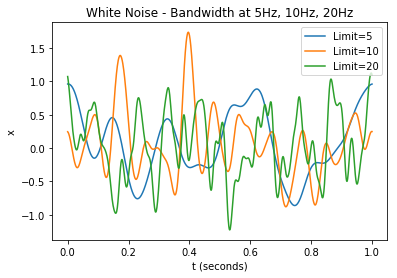

In [6]:
def generate_signal_with_g(T, dt, rms, bandwidth, seed=0):
    
    np.random.seed(seed=seed)
    
    number_of_samples = int(T/dt)
    frequencies=np.arange(number_of_samples)/T - number_of_samples/(2*T)
    X = np.zeros(len(frequencies)).tolist()
    
    for i, f in enumerate(frequencies):
        standard_deviation  = np.exp(-np.power(f,2)/(2*np.power(bandwidth,2)))
        if standard_deviation != 0:
            real, imag = np.random.normal(scale=standard_deviation), np.random.normal(scale=standard_deviation)*1j
            if f < 0: X[i] = real - imag
            else: X[i] = real + imag    
       
    x =np.fft.ifft(np.fft.ifftshift(X)).real
    x_rms = np.sqrt(np.mean(np.power(x,2)))
    x = [val*rms/(x_rms) for val in x]
    X = np.fft.fftshift(numpy.fft.fft(x))   
    return x,X

T,dt,rms = 1, 0.001, 0.5
number_of_samples = int(T/dt)
time = np.linspace(0, T, number_of_samples)

x5, X5 = generate_signal_with_g(T, dt, rms, 5, seed=5)
x10, X10 = generate_signal_with_g(T, dt, rms, 10, seed=5)
x20, X20 = generate_signal_with_g(T, dt, rms, 20, seed=5)


plt.figure()
plt.plot(time, x5, label='Limit=5')
plt.plot(time, x10, label='Limit=10')
plt.plot(time, x20, label='Limit=20')
plt.xlabel('t (seconds)')
plt.ylabel('x')
plt.title('White Noise - Bandwidth at 5Hz, 10Hz, 20Hz')
plt.legend()

2. [1 mark] Plot the average $|X(\omega)|$ (the norm of the Fourier coefficients) over 100 signals generated with ``T``=1, ``dt``=0.001, ``rms``=0.5, and ``bandwidth``=10 (each of these 100 signals should have a different ``seed``).

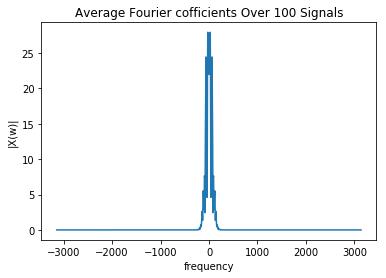

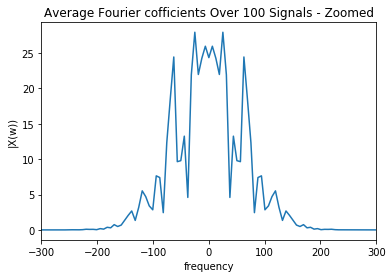

In [7]:
T, dt, rms, bandwidth,num_seeds = 1, 0.001, 0.1, 10,100
number_of_samples = int(T/dt)

frequencies = sorted(np.fft.fftfreq(number_of_samples,dt)) #freqs (Hz)
w = [2*np.pi*f for f in frequencies]

f_cofs = np.zeros((number_of_samples, 100))
X_array = []
for seed in range(num_seeds):
    x,X = generate_signal_with_g(T=T,dt=dt,rms=rms,bandwidth=bandwidth,seed=seed)
    X_array.append(X)
    f_cofs[:, seed] = np.abs(X)
        
X_array = np.array(X_array)
f_cofs_mean = np.mean(f_cofs, axis=1)
X_array_norm = [np.absolute(val) for val in X_array[:,]][0]


plt.figure()
plt.plot(w, X_array_norm)
plt.xlabel('frequency')
plt.ylabel('|X(w)|')
plt.title('Average Fourier cofficients Over 100 Signals')
plt.show()


plt.figure()
plt.plot(w, X_array_norm)
plt.xlabel('frequency')
plt.ylabel('|X(w))')
plt.title('Average Fourier cofficients Over 100 Signals - Zoomed')
plt.xlim([-300, 300])
plt.show()

## 2) Simulating a Spiking Neuron

Write a program to simulate a single Leaky-Integrate and Fire neuron.  The core equation is $ {{dV} \over {dt}} = {1 \over {\tau_{RC}}} (J - V)$ (to simplify life, this is normalized so that $R$=1, the resting voltage is 0 and the firing voltage is 1).  This equation can be simulated numerically by taking  small time steps (Euler's method).  When the voltage reaches the threshold $1$, the neuron will spike and then reset its voltage to $0$ for the next $\tau_{ref}$ amount of time (to plot this, place a dot or line at that time).  Also, if the voltage goes below zero at any time, reset it back to zero.  For this question, $\tau_{RC}$=0.02 and $\tau_{ref}$=0.002

Since we want to do inputs in terms of $x$, we need to do $J = \alpha e \cdot x + J^{bias}$.  For this neuron, set $e$ to $+1$ and find $\alpha$ and $J^{bias}$ such that the firing rate when $x=0$ is 40Hz and when $x=1$ it is 150Hz.  To find these $\alpha$ and $J^{bias}$ values, use the approximation for the LIF neuron $a(J)={1 \over {\tau_{ref}-\tau_{RC}ln(1-{1 \over J})}}$.

In [16]:
class LIFNeuron:
    
    def __init__(self, enc=1, tau_ref=0.002, tau_rc=0.02, min_rate=40, max_rate=150):
        self.min_rate = min_rate
        self.max_rate = max_rate
        self.enc = enc
        self.tau_ref = tau_ref
        self.tau_rc = tau_rc
            
    def get_spikes(self, x, dt):
        
        self.j_bias = 1/(1-np.exp((self.tau_ref-(1/self.min_rate))/self.tau_rc))
        self.alpha = 1/(1-np.exp((self.tau_ref-(1/self.max_rate))/self.tau_rc))-self.j_bias
        
        number_of_spikes = 0
        spikes = []
        v,i = 0,0
        while i < len(x):
            J = self.alpha*x[i]*self.enc + self.j_bias
            if v >= 1:
                v = 1.5
                number_of_spikes +=1
                if len(spikes) < len(x): spikes.append(v)
                v,j = 0,0
                while(j<self.tau_ref/dt):
                    i,j=i+1,j+1
                    if len(spikes) < len(x): spikes.append(v)
                v = v + dt*(1/self.tau_rc)*(J - v)
                i += 1        
                continue
            elif v < 0:
                v = 0
                if len(spikes) < len(x): spikes.append(v)
            else:    
                if len(spikes) < len(x): spikes.append(0)
           
            v = v + dt*(1/self.tau_rc)*(J - v)
            i += 1        
        return spikes, number_of_spikes

Spikes at x=0: 40


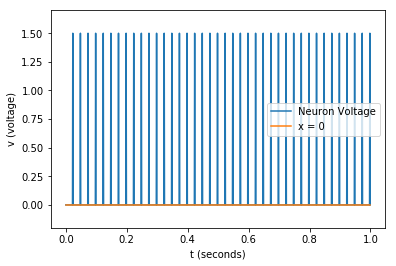

Spikes at x=1: 143


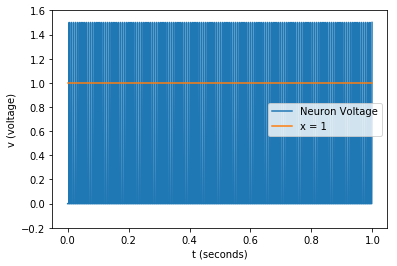

In [21]:
dt,T = 0.001,1
t = np.arange(0,T,dt)
n = LIFNeuron()


x = [0 for val in t]
spikes, num_spikes = n.get_spikes(x, dt)
print('Spikes at x=0:',num_spikes)

plt.plot(t, spikes, label='Neuron Voltage')
plt.plot(t, x, label='x = 0')
plt.ylim(-0.2,1.7)
plt.xlabel('t (seconds)')
plt.ylabel('v (voltage)')
plt.legend()
plt.show()


x = [1 for time in t]
spikes,num_spikes = n.get_spikes(x,dt)
print('Spikes at x=1:',num_spikes)

plt.plot(t, spikes, label='Neuron Voltage')
plt.plot(t, x, label='x = 1')
plt.ylim(-0.2,1.6)
plt.xlabel('t (seconds)')
plt.ylabel('v (voltage)')
plt.legend()
plt.show()

b. [1 mark] Does the observed number of spikes in the previous part match the expected number of spikes for $x=0$ and $x=1$?  Why or why not?  What aspects of the simulation would affect this accuracy?

***ANSWER***<br>
The number of spikes at x=0 is 40 (correct) and at x=1 is 143 (incorrect, it should be 150). The reason for the this behaviour is step integration error, which is high at big steps. Also, the error is induced from if statements in the simulation. Redefining the neuron voltage after it fires, and making it zero in "dt," drops its voltage below zero which causes error. To reduce this eror, we can decrease the step size. Please see the following table for improved performance:-

x=1, dt=0.001 -> 143 spikes<br>
x=1, dt=0.0001 -> 149 spikes<br>
x=1, dt=0.00001 -> 150 spikes<br>

c. [1 mark] Plot the spike output for $x(t)$ generated using your function from part 1.1.  Use ``T``=1, ``dt``=0.001, ``rms``=0.5, and ``limit``=30.  Overlay on this plot $x(t)$.

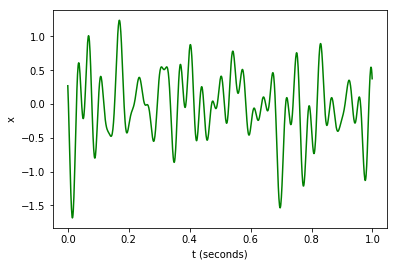

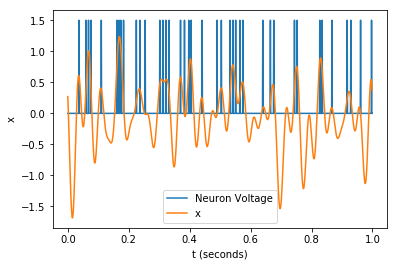

In [28]:
T, dt, rms, limit = 1, 0.001, 0.5, 30
x, X = generate_signal(T=T,dt=dt,rms=rms,limit=limit)

spikes,num_spikes = LIFNeuron().get_spikes(x,dt)

t = np.arange(0,T,dt)
plt.plot(t, x, label='Input x',color='g')
plt.xlabel('t (seconds)')
plt.ylabel('x')
plt.show()

plt.plot(t, spikes, label='Neuron Voltage')
plt.plot(t, x, label='x')
plt.xlabel('t (seconds)')
plt.ylabel('x')
plt.legend()
plt.show()

d. [1 mark] Using the same $x(t)$ signal as in part (c), plot the neuron's voltage over time for the first 0.2 seconds, along with the spikes over the same time.

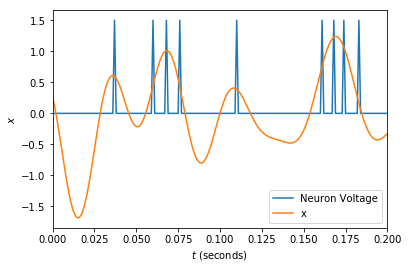

In [30]:
plt.plot(t, spikes, label='Neuron Voltage')
plt.plot(t, x, label='x')
plt.xlabel('$t$ (seconds)')
plt.ylabel('$x$')
plt.xlim(0.0,0.2)
plt.legend()
plt.show()

e. BONUS: How could you improve this simulation (in terms of how closely the model matches actual equation) without significantly increasing the computation time?  0.5 marks for having a good idea, and up to 1 marks for actually implementing it and showing that it works.

***Answer***<br>

The first obvious method for improving the accuracy of the spiking neuron simulation is to use a more accurate method for approximation beyond Euler's method. Examples of this includes Runge-Kutta and Heun's method. 

The next method for improving the accuracy of the spiking neuron simulation is to make the refractory period more accurate. In these areas, interpolation may be used in order to better approximate the next step's value if the time steps do not align well with the refractory periods.

In this assignment these possible improvements have not been implemented.





The simulation could be improved by replacing the step discontinuities with a steep continuous function such as a sigmoid function. This is the technique that Mathworks simulink uses whenever a user places a step function in their model.

## 3) Simulating Two Spiking Neurons

Write a program that simulates two neurons.  The two neurons have exactly the same parameters, except for one of them $e=1$ and for the other $e=-1$.  Other than that, use exactly the same settings as in question 2.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[0.5 marks] Plot $x(t)$ and the spiking output for $x(t)=0$ (both neurons should spike at ~40 spikes per second).</li>
</ol>

In [ ]:
dt = 0.001
T = 1
t = np.arange(0,T,dt)

# Constant reference signal of x = 0
x = [0 for time in t]

# Encoder of +1
spikes1,num_spikes1 = SpikingNeuron(enc=1).spikes(x,dt)
print('Number of spikes for neuron with encoder=(1):',num_spikes1)

# Encoder of -1
spikes2,num_spikes2 = SpikingNeuron(enc=-1).spikes(x,dt)
print('Number of spikes for neuron with encoder=(-1):',num_spikes2)

plt.plot(t, spikes1, label='Neuron Voltage, enc(+1)')
plt.plot(t, np.array(spikes2)*(-1), label='Neuron Voltage, enc( -1)')
plt.plot(t, x, label='Reference Signal')
plt.ylim(-1.6,1.6)
plt.xlabel('$t$ (seconds)')
plt.ylabel('$V$ (voltage) of neuron')
plt.legend()
plt.show()


# plt.plot(t, spikes2, label='Neuron Voltage, enc( -1)')
# plt.plot(t, x, label='Reference Signal')
# plt.xlabel('$t$ (seconds)')
# plt.ylabel('$V$ (voltage) of neuron')
# plt.ylim(-0.6,1.6)
# plt.legend()
# plt.show()

<ol style="list-style:lower-alpha outside none;" start="2">
<li>[0.5 marks] Plot $x(t)$ and the spiking output for $x(t)=1$ (one neuron should spike at ~150 spikes per second, and the other should not spike at all).</li>

In [ ]:
dt = 0.001
T = 1
t = np.arange(0,T,dt)

# Constant reference signal of x = 1
x = [1 for time in t]

# Encoder of +1
spikes1,num_spikes1 = SpikingNeuron(enc=1).spikes(x,dt)
print('Number of spikes for neuron with encoder=(1):',num_spikes1)

# Encoder of -1
spikes2,num_spikes2 = SpikingNeuron(enc=-1).spikes(x,dt)
print('Number of spikes for neuron with encoder=(-1):',num_spikes2)

plt.figure(figsize=(14, 3))
plt.plot(t, spikes1, label='Neuron Voltage')
plt.plot(t, np.array(spikes2)*(-1), label='Neuron Voltage')
plt.plot(t, x, label='Reference Signal')
plt.xlabel('$t$ (seconds)')
plt.ylabel('$V$ (voltage) of neuron')
plt.ylim(-0.2,1.6)
plt.legend()
plt.show()

<ol style="list-style:lower-alpha outside none;" start="3">
<li>[1 mark] Plot $x(t)$ and the spiking output for $x(t)={1 \over 2}sin(10\pi t)$ (a sine wave at 5Hz).</li>

In [ ]:
dt = 0.001
T = 1
t = np.arange(0,T,dt)

# Sine wave of 5 Hz
x = 0.5*np.sin(10*np.pi*t)

# Encoder of +1
spikes1,num_spikes1 = SpikingNeuron(enc=1).spikes(x,dt)
print('Number of spikes for neuron with encoder=(1):',num_spikes1)


# Encoder of -1
spikes2,num_spikes2 = SpikingNeuron(enc=-1).spikes(x,dt)
print('Number of spikes for neuron with encoder=(-1):',num_spikes2)

plt.plot(t, spikes1, label='Neuron Voltage, enc(+1)')
plt.plot(t, np.array(spikes2)*(-1), label='Neuron Voltage, enc(-1)')
plt.plot(t, x, label='Reference Signal')
plt.xlabel('$t$ (seconds)')
plt.ylabel('$V$ (voltage) of neuron')
plt.ylim(-1.6,1.6)
plt.legend()
plt.show()


# plt.plot(t, spikes2, label='Neuron Voltage, enc(-1)')
# plt.plot(t, x, label='Reference Signal')
# plt.xlabel('$t$ (seconds)')
# plt.ylabel('$V$ (voltage) of neuron')
# plt.ylim(-0.6,1.6)
# plt.legend()
# plt.show()

<ol style="list-style:lower-alpha outside none;" start="4">
<li>[1 mark] Plot $x(t)$ and the spiking output for a random signal generated with your function for question 1.1 with ``T``=2, ``dt``=0.001, ``rms``=0.5, and ``limit``=5.</li>
</ol>

In [ ]:
T,dt,rms,limit, seed = 2, 0.001, 0.5, 5, 3
t = np.arange(0,T,dt)

# Random signal of max 5 Hz
x_3d,X_3d = generate_signal(T=T,dt=dt,rms=rms,limit=limit,seed=seed)

# Encoder of +1
spikes1,num_spikes1 = SpikingNeuron(enc=1).spikes(x_3d,dt)
print('Number of spikes for neuron with encoder=(1):',num_spikes1)

# Encoder of -1
spikes2,num_spikes2 = SpikingNeuron(enc=-1).spikes(x_3d,dt)
print('Number of spikes for neuron with encoder=(-1):',num_spikes2)

spikes_3d = [spikes1, spikes2]



plt.plot(t, spikes1, label='Neuron Voltage, enc(+1)')
plt.plot(t, np.array(spikes2)*(-1), label='Neuron Voltage, enc(-1)')
plt.plot(t, x_3d, label='Reference Signal')
plt.xlabel('$t$ (seconds)')
plt.ylabel('$V$ (voltage) of neuron')
plt.ylim(-1.6,1.6)
plt.legend()
plt.show()

# plt.plot(t, spikes2, label='Neuron Voltage')
# plt.plot(t, x_3d, label='Reference Signal')
# plt.xlabel('$t$ (seconds)')
# plt.ylabel('$V$ (voltage) of neuron')
# plt.ylim(-0.6,1.6)
# plt.legend()
# plt.show()


 ## 4) Computing an Optimal Filter

Compute the optimal filter for decoding pairs of spikes.  Instead of implementing this yourself, here is an implementation in <a href="files/assignment2/optimal_filter.py">Python</a> and an implementation in <a href="files/assignment2/optimal_filter.m">Matlab</a>.  

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[1 mark] Document the code and connect it with the code you wrote for part (3) so that it uses the signal used in 3.d.  Comments should be filled in where there are ``#`` signs (Python) or ``%`` signs (Matlab).  Replace the ``'???'`` labels in the code with the correct labels.  Note that you can use the generated plots for the next few parts of this question.</li>

In [ ]:
# doing it this way give the same result

def two_neurons2(x, dt, alpha, Jbias, tau_rc=0.02, tau_ref=0.002):
    x=np.array(x)
    J=np.zeros([2,x.size]) # J related to two spiking neurons
    V=np.zeros([2,x.size])
    Spikes=np.zeros([2,x.size])

    J[0]=alpha*x+Jbias   #On Neuron Current
    J[1]=-alpha*x+Jbias  #Off Neuron Current


    for n in range(2):
        i=1 
        while i<x.size:
            V[n,i]=V[n,i-1]+1/tau_rc*(J[n,i-1]-V[n,i-1])*dt
            if V[n,i]<0:
                V[n,i]=0
            if V[n,i]>1:
                V[n,i]=0
                Spikes[n,i]=1 
                i+=int(tau_ref/dt)
            else:     
                i+=1
    return  Spikes[0], Spikes[1]



def two_neurons(x, dt, alpha, j_bias, tau_rc, tau_ref):
        spikes = []
        for enc in [1,-1]:
            voltages = []
            v,i = 0,0
            
            while i < len(x):
                J = alpha*x[i]*enc + j_bias
                if v >= 1: #spike
                    v = 1 #constant spike voltage
                    if len(voltages) < len(x): voltages.append(v)
                    v,j = 0,0
                    while(j<int(tau_ref/dt)):
                        i=i+1
                        j=j+1
                        if len(voltages) < len(x): voltages.append(v)        
                    v = v + (1/tau_rc)*(J - v)*dt
                    i += 1     
                elif v < 0:
                    v = 0
                    if len(voltages) < len(x): voltages.append(v)
                    v = v + (1/tau_rc)*(J - v)*dt
                    i += 1  
                else:    
                    if len(voltages) < len(x): voltages.append(v)
                    v = v + (1/tau_rc)*(J - v)*dt
                    i += 1        
                    
            spikes.append(np.array(voltages))
        return spikes[0],spikes[1]


T = 4.0         # length of signal in seconds
dt = 0.001      # time step size

# [Generate white noise (same seed as section 3(d))]
x, X = generate_signal(T=T, dt=dt, rms=0.5, limit=5, seed=5)


Nt = len(x)                # [Number of time samples]
t = numpy.arange(Nt) * dt  # [Time range values (seconds)]

# Neuron parameters
tau_ref = 0.002          # [Refractory period (seconds)]
tau_rc = 0.02            # [Resistor-Capacitor (RC) constant]
x0 = 0.0                 # firing rate at x=x0 is a0
a0 = 40.0
x1 = 1.0                 # firing rate at x=x1 is a1
a1 = 150.0

# [Calculate J_bias and alpha for our neuron models]
eps = tau_rc/tau_ref
r1 = 1.0 / (tau_ref * a0)
r2 = 1.0 / (tau_ref * a1)
f1 = (r1 - 1) / eps
f2 = (r2 - 1) / eps
alpha = (1.0/(numpy.exp(f2)-1) - 1.0/(numpy.exp(f1)-1))/(x1-x0) 
x_threshold = x0-1/(alpha*(numpy.exp(f1)-1))              
Jbias = 1-alpha*x_threshold;

# [Simulate the two spiking neurons (from part 3)]
spikes = np.array(two_neurons(x, dt, alpha, Jbias, tau_rc, tau_ref))


freq = numpy.arange(Nt)/T - Nt/(2.0*T)   # [Generate set of frequency values]
omega = freq*2*numpy.pi                  # [Convert Hertz to radians]

r = np.array(spikes[0]) - np.array(spikes[1])                # [Spike responses are opposites of each other]
R = np.array(numpy.fft.fftshift(numpy.fft.fft(r))) # [Take response into frequency domain and shift (center) it]
X = np.array(X)                          # [Do data type conversion]

sigma_t = 0.025                          # [Standard deviation of 0.025]
W2 = numpy.exp(-omega**2*sigma_t**2)     # [Gaussian curve over frequencies with stddev of sigma_t]
W2 = W2 / sum(W2)                        # [Normalize to sum to 1 so magnitude of signals aren't affected during convolution]

CP = X*R.conjugate()                  # 
WCP = numpy.convolve(CP, W2, 'same')  # 
RP = R*R.conjugate()                  # [Make response real by multiplying by conjugate]
WRP = numpy.convolve(RP, W2, 'same')  # [Make response continuous and smooth by convolving with Gaussian filter]
XP = X*X.conjugate()                  # [Make stimuli real by multiplying by conjugate]
WXP = numpy.convolve(XP, W2, 'same')  # [Make stimuli continuous and smooth by convolving with Gaussian filter]

H = WCP / WRP                         # [Get the filter]

h = numpy.fft.fftshift(numpy.fft.ifft(numpy.fft.ifftshift(H))).real  # [Take filter into time domain]

XHAT = H*R                            # [Approximate freq-domain representation using filter and response]

xhat = numpy.fft.ifft(numpy.fft.ifftshift(XHAT)).real  # [Get time-domain approximation of stimuli]


import pylab

pylab.figure(1)
pylab.subplot(1,2,1)
pylab.plot(freq, numpy.sqrt(XP), label='Stim. power spectrum')  # [Real part response needs to be sqrt'd after having been 'squared' by conjugate]
pylab.legend()
pylab.xlabel('$\omega$ (radians)')
pylab.ylabel('$|X(\omega)|$')

pylab.subplot(1,2,2)
pylab.plot(freq, numpy.sqrt(RP), label='Spike response spectrum')  # [Real part response needs to be sqrt'd after having been 'squared' by conjugate]
pylab.legend()
pylab.xlabel('$\omega$ (radians)')
pylab.ylabel('$|R(\omega)|$')


pylab.figure(2)
pylab.subplot(1,2,1)
pylab.plot(freq, H.real)   # [Take real part of the filter]
pylab.xlabel('$\omega$ (radians)')
pylab.title('Optimal Filter Spectrum')
pylab.xlim(-50, 50)

pylab.subplot(1,2,2)
pylab.plot(t-T/2, h)       # [Filter in time-domain]
pylab.title('Optimal Fitler in Time-Domain')
pylab.xlabel('$t$ (seconds)')
pylab.xlim(-0.5, 0.5)


pylab.figure(5)
pylab.plot(t, r, color='k', label='Spiking activity', alpha=0.2)  # [Responses]
pylab.plot(t, x, linewidth=2, label='Stimuli (signal)')           # [Input signal]
pylab.plot(t, xhat, label='Neuron representation of signal')      # [Temporal representation]
pylab.title('Representation of Temporal Stimuli')
pylab.legend(loc='best')
pylab.xlabel('$t$ (seconds)')

pylab.show()

<ol style="list-style:lower-alpha outside none;" start="2">
<li>[1 mark] Plot the time and frequency plots for the optimal filter for the signal you generated in question 3.d.</li>
</ol>

In [ ]:
np.set_printoptions(threshold=numpy.nan)


T = 2.0         # length of signal in seconds
dt = 0.001      # time step size
rms=0.5
limit=5


x, X = x_3d, X_3d
spikes = np.array(spikes_3d)


# X = numpy.fft.fftshift(X) #HOLAAAAAAAAAAAA
X=np.array(X)
Nt = len(x)               #HOLAAAAAAAAAAAA
t = numpy.arange(Nt) * dt #HOLAAAAAAAAAAAA

freq = numpy.arange(Nt)/T - Nt/(2.0*T)  
omega = freq*2*numpy.pi   

r = spikes[0] - spikes[1]                # Calculate the difference of spikes to get 1-dimensional spike train signal
R = np.fft.fftshift(np.fft.fft(r))             # FFT of spike train signal

sigma_t = 0.025                          # Stdev of window size
W2 = np.exp(-omega**2*sigma_t**2)        # Create gaussian window
W2 = W2 / sum(W2)                        # Normalize window function to an area of 1

CP = X*R.conjugate()                  # Numerator for filter transfer function H
WCP = np.convolve(CP, W2, 'same')     # Time domain window of the numerator 
RP = R*R.conjugate()                  # Denominator for filter transfer function H. |R(w)|^2
WRP = np.convolve(RP, W2, 'same')     # Time domain window of the numerator 
XP = X*X.conjugate()                  # Square of X |X(w)|^2
WXP = np.convolve(XP, W2, 'same')     # Time domain window of the above line

H = WCP / WRP                         # Calculate the optimal filter

h = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(H))).real  # Convert filter to time domain 

XHAT = H*R  # Decode the spike train

xhat = np.fft.ifft(np.fft.ifftshift(XHAT)).real  # Convert decoded signal to time domain\


import pylab

# print(freq.shape)
# print(H.real.shape)


pylab.figure()

pylab.plot(freq, H.real)   # Plot the real part of the Optimal filter
pylab.xlabel('$\omega$')
pylab.title('Optimal Filter')
pylab.xlim(-50, 50)
pylab.show()

pylab.plot(t,h)       # Plot the positive time portion of the optimal filter in time domain
pylab.title('Time Domain Optimal Filter')
pylab.xlabel('$t$')
pylab.show()

<ol style="list-style:lower-alpha outside none;" start="3">
<li>[1 marks] Plot the $x(t)$ signal, the spikes, and the decoded $\hat{x}(t)$ value for the signal in question 3.d.</li>
</ol>

In [ ]:
pylab.figure()
pylab.plot(t, r, color='k', label='Spikes', alpha=0.2)  # Plot the spike train
pylab.plot(t, x, linewidth=2, label='Input Signal')           # Plot the input signal
pylab.plot(t, xhat, label='Reconstructed Signal')             # Plot the reconstructed signal from spike trains
pylab.title('Reconstructed Signal')
pylab.legend(loc='best')
pylab.xlabel('$time$')
pylab.show();

<ol style="list-style:lower-alpha outside none;" start="4">
<li>[1 marks] Plot the $|X(\omega)|$ power spectrum, $|R(\omega)|$ spike response spectrum, and the $|\hat{X}(\omega)|$ power spectrum for the signal in question 3.d. How do these relate to the optimal filter?</li>
</ol>

In [ ]:
pylab.figure(figsize=(15,3))
pylab.plot(freq, np.sqrt(XP), label='$|X(\omega)|$')  # Plot vector norm of input signal in frequency domain
pylab.legend()
pylab.xlabel('$\omega$')
pylab.ylabel('$|X(\omega)|$')

pylab.figure(figsize=(15,3))
pylab.plot(freq, np.sqrt(RP), label='$|R(\omega)|$')  # Plot vector norm of spike train in frequency domain
pylab.legend()
pylab.xlabel('$\omega$')
pylab.ylabel('$|R(\omega)|$')

pylab.figure(figsize=(15,3))
pylab.plot(freq, np.sqrt(XHAT*XHAT.conjugate()), label='$|X\hat(\omega)|$')  # Plot vector norm of spike train in frequency domain
pylab.legend()
pylab.xlabel('$\omega$')
pylab.ylabel('$|X\hat(\omega)|$')

pylab.show()

<ol style="list-style:lower-alpha outside none;" start="5">
<li>[1 mark] Generate $h(t)$ time plots for the optimal filter for different ``limit`` values of 2Hz, 10Hz, and 30Hz.  Describe the effects on the time plot of the optimal filter as the ``limit`` increases.  Why does this happen?</li>
</ol>

In [ ]:
def optimalFilter(T, dt, tau_rc, tau_ref, limit, seed):

    # Generate bandlimited white noise (use your own function from part 1.1)
    x, X = generate_signal(T = T, dt=dt, rms=0.5, limit=limit, seed = seed)
#     X = np.fft.fftshift(fft.fft(x))    # generate_signal returns rfft

    Nt = len(x)                # Number of time samples
    t = np.arange(Nt) * dt     # Set the time array
    
    
    x0 = 0.0                 # firing rate at x=x0 is a0
    a0 = 40.0
    x1 = 1.0                 # firing rate at x=x1 is a1
    a1 = 150.0

    # [Calculate J_bias and alpha for our neuron models]
    eps = tau_rc/tau_ref
    r1 = 1.0 / (tau_ref * a0)
    r2 = 1.0 / (tau_ref * a1)
    f1 = (r1 - 1) / eps
    f2 = (r2 - 1) / eps
    alpha = (1.0/(numpy.exp(f2)-1) - 1.0/(numpy.exp(f1)-1))/(x1-x0) 
    x_threshold = x0-1/(alpha*(numpy.exp(f1)-1))              
    Jbias = 1-alpha*x_threshold;

    X=np.array(X)
    
    # Simulate the two neurons (use your own function from part 3)
    spikes = np.array(two_neurons(x, dt, alpha, Jbias, tau_rc, tau_ref))
#     spikes = two_neurons.spikeTrains(x=x)

    freq = np.arange(Nt)/T - Nt/(2.0*T)      # Set the Frequency array (in Hz) for plotting
    omega = freq*2*np.pi                        # Convert the Frequency array to rad/s

    r = spikes[0] - spikes[1]                # Calculate the difference of spikes to get 1-dimensional spike train signal
    R = np.fft.fftshift(np.fft.fft(r))             # FFT of spike train signal

    sigma_t = 0.025                          # Stdev of window size
    W2 = np.exp(-omega**2*sigma_t**2)        # Create gaussian window
    W2 = W2 / sum(W2)                        # Normalize window function to an area of 1

    CP = X*R.conjugate()                  # Numerator for filter transfer function H
    WCP = np.convolve(CP, W2, 'same')     # Time domain window of the numerator 
    RP = R*R.conjugate()                  # Denominator for filter transfer function H. |R(w)|^2
    WRP = np.convolve(RP, W2, 'same')     # Time domain window of the numerator 
    XP = X*X.conjugate()                  # Square of X |X(w)|^2
    WXP = np.convolve(XP, W2, 'same')     # Time domain window of the above line

    H = WCP / WRP                         # Calculate the optimal filter

    h = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(H))).real  # Convert filter to time domain 

    XHAT = H*R                            # Decode the spike train

    xhat = np.fft.ifft(np.fft.ifftshift(XHAT)).real  # Convert decoded signal to time domain
    
    return t, x, xhat

In [ ]:
t, x, xhat = optimalFilter(T = 1, dt = 0.001, tau_rc = 0.02, tau_ref = 0.002, limit = 2, seed = 1)

# figure()
plt.plot(t,x)
plt.plot (t,xhat)
plt.title('Reconstructed signal - 2 Hz')
plt.xlabel('$t$');
plt.show()

In [ ]:
t, x, xhat = optimalFilter(T = 1, dt = 0.001, tau_rc = 0.02, tau_ref = 0.002, limit = 10, seed = 1)

# figure()
plt.plot(t,x)
plt.plot (t,xhat)
plt.title('Reconstructed signal - 2 Hz')
plt.xlabel('$t$');
plt.show()

In [ ]:
t, x, xhat = optimalFilter(T = 1, dt = 0.001, tau_rc = 0.02, tau_ref = 0.002, limit = 30, seed = 1)

# figure()
plt.plot(t,x)
plt.plot (t,xhat)
plt.title('Reconstructed signal - 2 Hz')
plt.xlabel('$t$');
plt.show()

## 5) Using Post-Synaptic Currents as a Filter

NOTE TO CHRIS: Update this to force people to not use convolution; they keep using it in future assignments and it degrades their understanding and quality of their simulations.

Instead of using the optimal filter from the previous question, now we will use the post-synaptic current instead.  This is of the form $h(t)=t^n e^{-t/\tau}$ normalized to area 1.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[1 mark] Plot the normalized $h(t)$ for $n$=0, 1, and 2 with $\tau$=0.007 seconds.  What two things do you expect increasing $n$ will do to $\hat{x}(t)$?</li>
</ol>

In [ ]:
T = 2
dt = 0.001
number_of_samples = int(T/dt)
noise_std = 0.2
t = np.linspace(0, T, number_of_samples)  # HOLAAAAAAAAAAAAAA

def generate_ht(t, n, tau):
    h = t**n * np.exp(-t/tau)
    h[np.where(t<0)]=0 # HOLAAAAAAAAAAAAAAAA
    h = h/np.linalg.norm(h,1) # normalize to area 1
    return h

t = np.linspace(-T/2, T/2, N) # HOLAAAAAAAAAAAAAA
tau = 0.007
ht_0 = generate_ht(t, 0, tau)
ht_1 = generate_ht(t, 1, tau)
ht_2 = generate_ht(t, 2, tau)


plt.figure(figsize=(15,3))
plt.plot(t, ht_0, label='n=0')
plt.plot(t, ht_1, label='n=1')
plt.plot(t, ht_2, label='n=2')
plt.title('h(t) - n=0, n=1, n=2')
plt.xlabel('t')
plt.ylabel('h(t)')
plt.legend()
plt.show()

<ol style="list-style:lower-alpha outside none;" start="2">
<li>[1 mark] Plot the normalized $h(t)$ for $\tau$=0.002, 0.005, 0.01, and 0.02 seconds with $n$=0.  What two things do you expect increasing $\tau$ will do to $\hat{x}(t)$?</li>
</ol>

In [ ]:
ht_0 = generate_ht(t, 0, 0.002)
ht_1 = generate_ht(t, 0, 0.005)
ht_2 = generate_ht(t, 0, 0.01)
ht_3 = generate_ht(t, 0, 0.02)


plt.figure(figsize=(15,3))
plt.plot(t, ht_0, label='tau=0.002')
plt.plot(t, ht_1, label='tau=0.005')
plt.plot(t, ht_2, label='tau=0.01')
plt.plot(t, ht_3, label='tau=0.02')
plt.title('5B: h(t) for tau=0.002, tau=0.005, tau=0.01, tau=0.02')
plt.xlabel('t')
plt.ylabel('h(t)')
plt.legend()
plt.show()

<ol style="list-style:lower-alpha outside none;" start="3">
<li>[1 mark] Decode $\hat{x}(t)$ from the spikes generated in question 3.d using an $h(t)$ with $n$=0 and $\tau$=0.007.  Do this by generating the spikes, filtering them with $h(t)$, and using that as your activity matrix $A$ to compute your decoders.  Plot the time and frequency plots for this $h(t)$.  Plot the $x(t)$ signal, the spikes, and the decoded $\hat{x}(t)$ value.</li>
</ol>

In [ ]:
def generate_decoders(A, X, dt, noise_std):
    Ypsilon = dt * np.matmul(A.T,X)
    Gamma = dt * np.matmul(A.T, A)
    Gamma_inv = np.linalg.pinv(Gamma)
    d = np.dot(Gamma_inv, Ypsilon)
    return d


ht = generate_ht(t, 0, 0.007)

fspikes15c = np.convolve(spikes_3d[0], ht, mode='same')
fspikes25c = np.convolve(spikes_3d[1], ht, mode='same')

A5c = np.array([fspikes15c, fspikes25c]).T
d5c = generate_decoders(A5c, x_3d, dt, noise_std)
xhat5c = np.dot(A5c, d5c)


diff_spikes3d = np.array(spikes_3d[0]) - np.array(spikes_3d[1])


# generate frequency plot H(w)
dw = 2*np.pi/T #HOLAAAAAAAAAAAAAAA
freq = np.array([dw*n if n<number_of_samples/2 else dw*(n-number_of_samples) for n in range(number_of_samples)]) #HOLAAAAAAAAAAAAAAA
H_w_n0 = np.fft.fft(ht) #HOLAAAAAAAAAAAAAAA


plt.figure(figsize=(14,3))
plt.plot(t, ht)
plt.ylabel('h(t)')
plt.xlabel('t')
plt.title('5C: Time domain h(t) plot')
# plt.xlim([-.2, 0.2])
plt.figure(figsize=(14,3))
plt.plot(np.fft.fftshift(freq), np.abs(np.fft.fftshift(H_w_n0)))
plt.ylabel('H(w)')
plt.xlabel('w')
plt.title('Frequency Domain H(w) plot')
plt.show()

In [ ]:
# print ("5C RMSE Decoding signals: {}".format(rms_error(x_t2, xhat5c)))
plt.figure(figsize=(14,3))
plt.plot(t, diff_spikes3d, 'k', label='Spikes', alpha=0.2)
plt.plot(t, xhat5c, label='xhat')
plt.plot(t, x_3d, 'r', label='x(t)')
plt.ylabel('H(w)')
plt.xlabel('w')
plt.legend()
plt.title('5C x(t), spikes and decoded signal')
plt.show()

<ol style="list-style:lower-alpha outside none;" start="4">
<li>[1 mark] Use the same decoder and $h(t)$ as in part (c), but generate a new $x(t)$ with ``limit``=2Hz.  Plot the $x(t)$ signal, the spikes, and the decoded $\hat{x}(t)$ value.  How do these decodings compare?</li>
</ol>

In [ ]:
def rms_error(a, b):
    return np.sqrt(np.mean(np.squeeze(np.asarray(a-b))**2))



T = 2
dt = 0.001
rms = 0.5
limit = 2
N = int(T/dt)

x_t25d, _ = generate_signal(T, dt, rms, limit, seed=21)



# Neuron parameters
tau_ref = 0.002          # [Refractory period (seconds)]
tau_rc = 0.02            # [Resistor-Capacitor (RC) constant]
x0 = 0.0                 # firing rate at x=x0 is a0
a0 = 40.0
x1 = 1.0                 # firing rate at x=x1 is a1
a1 = 150.0

# [Calculate J_bias and alpha for our neuron models]
eps = tau_rc/tau_ref
r1 = 1.0 / (tau_ref * a0)
r2 = 1.0 / (tau_ref * a1)
f1 = (r1 - 1) / eps
f2 = (r2 - 1) / eps
alpha = (1.0/(numpy.exp(f2)-1) - 1.0/(numpy.exp(f1)-1))/(x1-x0) 
x_threshold = x0-1/(alpha*(numpy.exp(f1)-1))              
Jbias = 1-alpha*x_threshold;






spikes5d = np.array(two_neurons(x_t25d, dt, alpha, Jbias, tau_rc, tau_ref))
# print ("Number of Spikes with white signal T=2, dt=0.001, rms=0.5, and limit=5: {}".format(nspikes1))
# print ("Number of Spikes with white signal T=2, dt=0.001, rms=0.5, and limit=5: {}".format(nspikes2))

fspikes1_5d = np.convolve(spikes5d[0], ht, mode='same')
fspikes2_5d = np.convolve(spikes5d[1], ht, mode='same')

A5d = np.array([fspikes1_5d, fspikes2_5d]).T
xhat5d = np.dot(A5d, d5c)


diff_spikes5d = spikes5d[0] - spikes5d[1]
print ("5D RMSE Decoding signals: {}".format(rms_error(x_t25d, xhat5d)))



plt.figure(figsize=(14,3))
plt.plot(t, diff_spikes5d, 'k', label='Spikes', alpha=0.2)
plt.plot(t, xhat5d, label='xhat')
plt.plot(t, x_t25d, 'r', label='x(t)')
plt.ylabel('')
plt.xlabel('')
plt.legend()
plt.title('5D x(t) and filtered spikes')
plt.show()